In [1366]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import data_utils
importlib.reload(data_utils)
import data_pipeline
importlib.reload(data_pipeline)
from data_pipeline import DataPipeline
import draw_utils
importlib.reload(draw_utils)
import linreg_utils
importlib.reload(linreg_utils)

<module 'linreg_utils' from 'c:\\Users\\BinaryCat17\\Documents\\Projects\\innopolis_course\\linreg_utils.py'>

## Загрузка и преобразование данных

In [1367]:
pipe = DataPipeline('generate_data')
pipe.generate('dataset', pd.read_csv, filepath_or_buffer="_file")
pipe.transform('dataset', 'features', lambda df: df.drop('Price(euro)', axis=1))
pipe.transform('dataset', 'labels', lambda df: df['Price(euro)'])
pipe.transform('features', 'features_names', lambda f: f.columns)
pipe.transform('features', 'X', lambda df: df.to_numpy())
pipe.transform('labels', 'Y', lambda df: np.matrix(df.to_numpy()).T)
pipe.transform(['X', 'Y'], ['X_train', 'X_test', 'Y_train', 'Y_test'], data_utils.split_test_train, train_percent=0.8)
cars_cat_num = pipe.process_copy("cat_num", _file='data/cars_cat_num.csv')
cars_onehot = pipe.process_copy("onehot", _file='data/cars_onehot.csv')

### Подготовка данных

In [1368]:
prepare = DataPipeline('prepare_data')
prepare.transform('X', ['X', 'X_min', 'X_max'], data_utils.minmax_features, p_enable='_minmax')
prepare.transform('Y', ['Y', 'Y_min', 'Y_max'], data_utils.minmax_features, p_enable='_minmax')

prepare.transform('X', ['X', 'X_mean', 'X_std'], data_utils.std_scale_features, p_enable='_std')
prepare.transform('Y', ['Y', 'Y_mean', 'Y_std'], data_utils.std_scale_features, p_enable='_std')

prepare.transform('X', 'X', data_utils.prepare_features, poly="_poly")

In [1369]:
load_train = DataPipeline('train')
load_train.transform(['X_train', 'Y_train'], ['X', 'Y'], (lambda X, Y: (X, Y)))

load_test = DataPipeline('test')
load_test.transform(['X_test', 'Y_test'], ['X', 'Y'], (lambda X, Y: (X, Y)))

## Задание модели

### Градиентный спуск

In [1370]:
gd_epoch = DataPipeline('gd_epoch')
gd_epoch.transform(['X', 'Y'], ['X_batch', 'Y_batch'], data_utils.take_random_batch, batch_size="_batch")
gd_epoch.transform(['X_batch', 'W'], 'Y_pred', linreg_utils.predict)
gd_epoch.transform(['X_batch', 'Y_batch', 'W'], 'grad_loss', linreg_utils.grad_loss)
gd_epoch.transform(['W', 'grad_loss'], 'W', linreg_utils.update_weights, lr="_lr")
gd_epoch.transform(['Y_batch', 'Y_pred'], 'RMSE', linreg_utils.RMSE, store_history=True)

linear_regression = DataPipeline('linear_regression')
linear_regression.subpipeline(load_train)
linear_regression.subpipeline(prepare)
linear_regression.transform('X', 'W', linreg_utils.generate_weights)
linear_regression.subpipeline(gd_epoch, p_repeat="_epochs")

### Оценка результатов

In [1371]:
test_model = DataPipeline('test_model')
test_model.subpipeline(prepare)
test_model.transform('Y', 'Y_orig', lambda Y: Y)
test_model.transform(['Y_orig', 'Y_min', 'Y_max'], 'Y_orig', data_utils.revert_minmax, p_enable="_minmax")
test_model.transform(['Y_orig', 'Y_mean', 'Y_std'], 'Y_orig', data_utils.revert_std_scale, p_enable="_std")
test_model.transform(['X', 'W'], 'Y_pred', linreg_utils.predict)
test_model.transform(['Y_pred', 'Y_min', 'Y_max'], 'Y_pred', data_utils.revert_minmax, p_enable="_minmax")
test_model.transform(['Y_pred', 'Y_mean', 'Y_std'], 'Y_pred', data_utils.revert_std_scale, p_enable="_std")
test_model.transform(['Y_pred', 'Y_orig'], 'RMSE', linreg_utils.RMSE)

In [1372]:
def test_models(pipes):
    def draw_res(stats=[]):
        def do_draw_res(ax, p):
            min = p.val('Y').min()
            max = p.val('Y').max()
            ax.scatter(np.array(p.val('Y_orig')), np.array(p.val('Y_pred')), label="scatter")
            ax.plot([min, max], [min, max], 'r')
            ax.set_xlabel('orig')
            ax.set_ylabel('pred')
            draw_utils.draw_stats(ax, p, stats)
        return do_draw_res

    draw_utils.draw_plots(pipes, draw_res(["RMSE"]))

In [1373]:
def train_and_test(data, model, model_args = {}, prepare_args = {}):
    model = model.apply_copy("", data, **model_args)
    draw_weights = draw_utils.draw_compare_stats('W', labels= ['bias'] + list(model.val('features_names')))
    draw_utils.draw_plots([model], [draw_utils.draw_metric(["RMSE"]), draw_weights], max_cols=1, title="linear_regression")

    train_pipe = DataPipeline.compose_apply("train", model, [load_train, test_model], **prepare_args)
    test_pipe = DataPipeline.compose_apply("test", model, [load_test, test_model], **prepare_args)
    pipes = [train_pipe, test_pipe]
    test_models(pipes)

## Обучение и тестирование линейной регрессии

### На категориальных данных, преобразованных в числовые

#### Без предварительной обработки

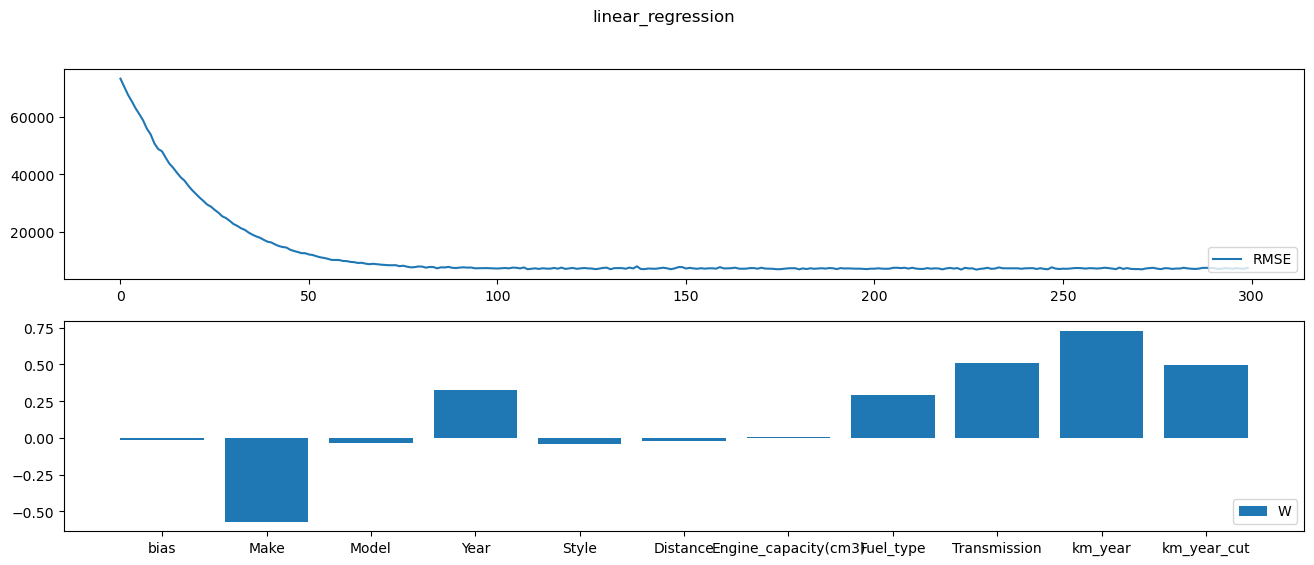

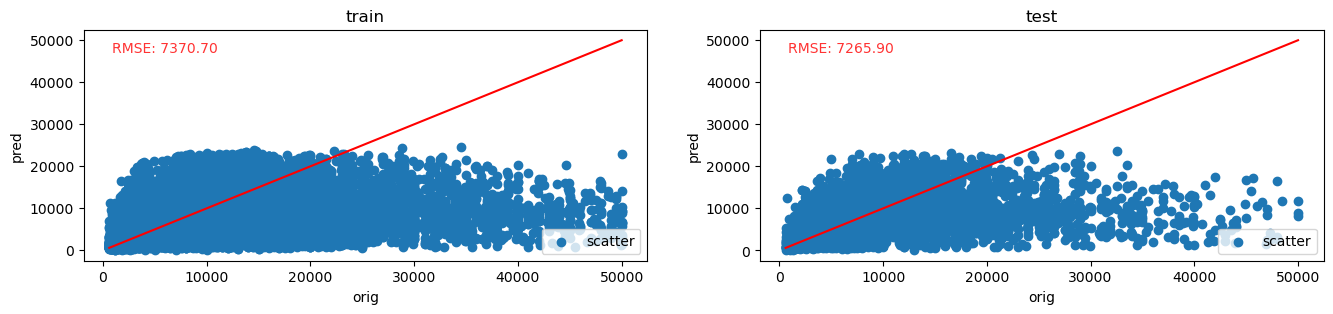

In [1374]:
train_and_test(cars_cat_num, linear_regression, {"_lr":1e-12, "_batch":5000, "_epochs":300})

#### На нормализованном наборе данных

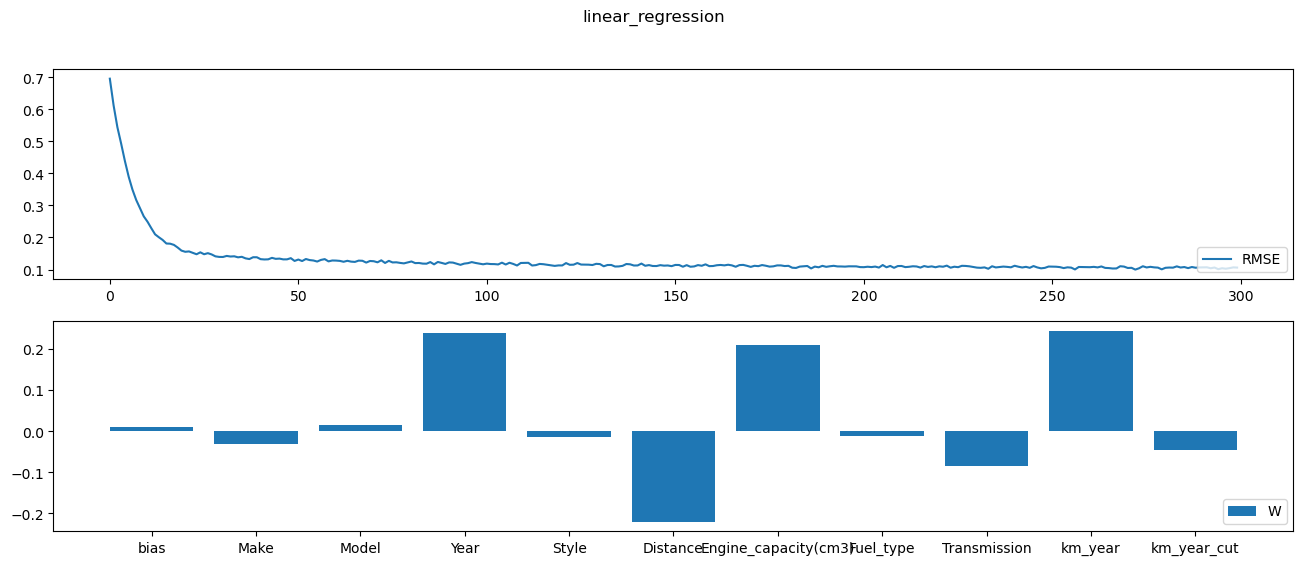

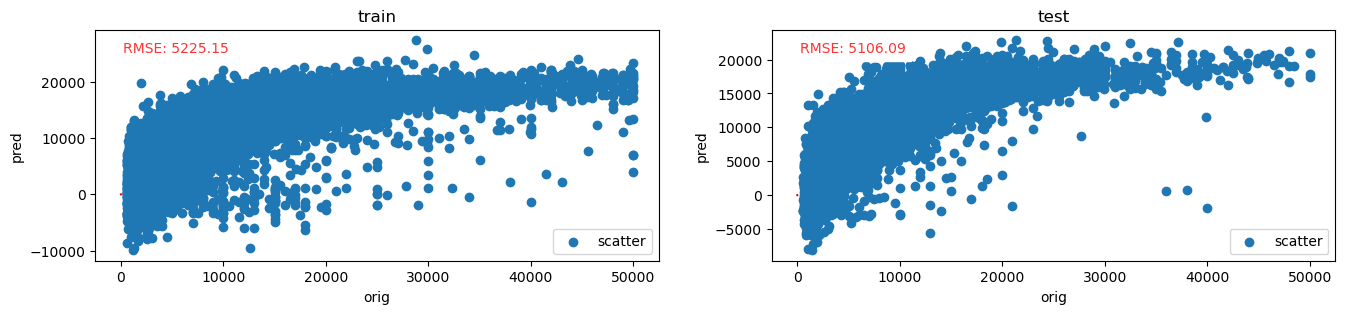

In [1375]:
train_and_test(cars_cat_num, linear_regression, {"_minmax": True, "_lr":0.5, "_batch":5000, "_epochs":300}, {"_minmax": True})

#### На стандартизированном наборе данных

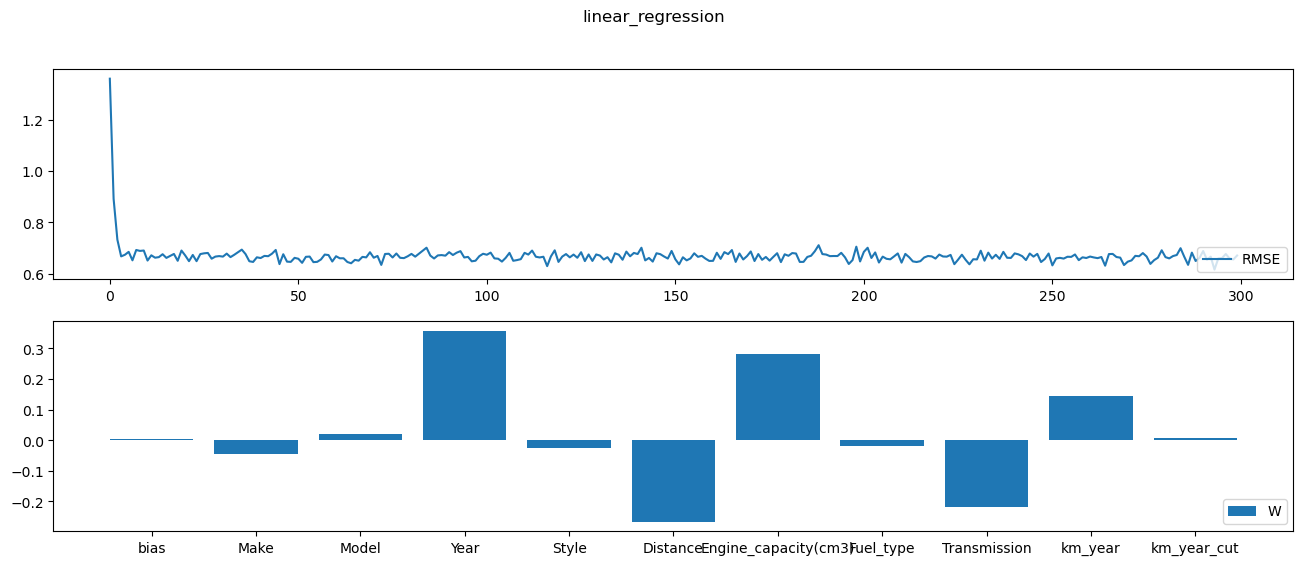

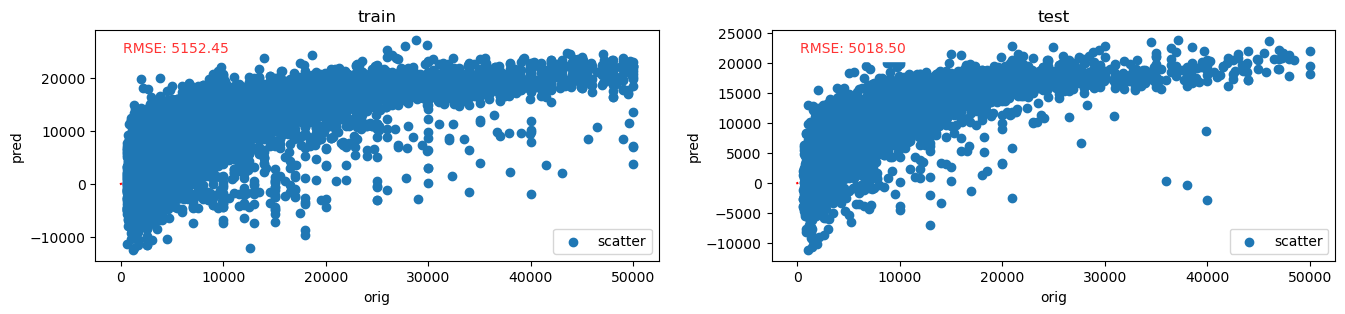

In [1376]:
train_and_test(cars_cat_num, linear_regression, {"_std": True, "_lr":0.5, "_batch":5000, "_epochs":300}, {"_std": True})

### На one-hot encoding

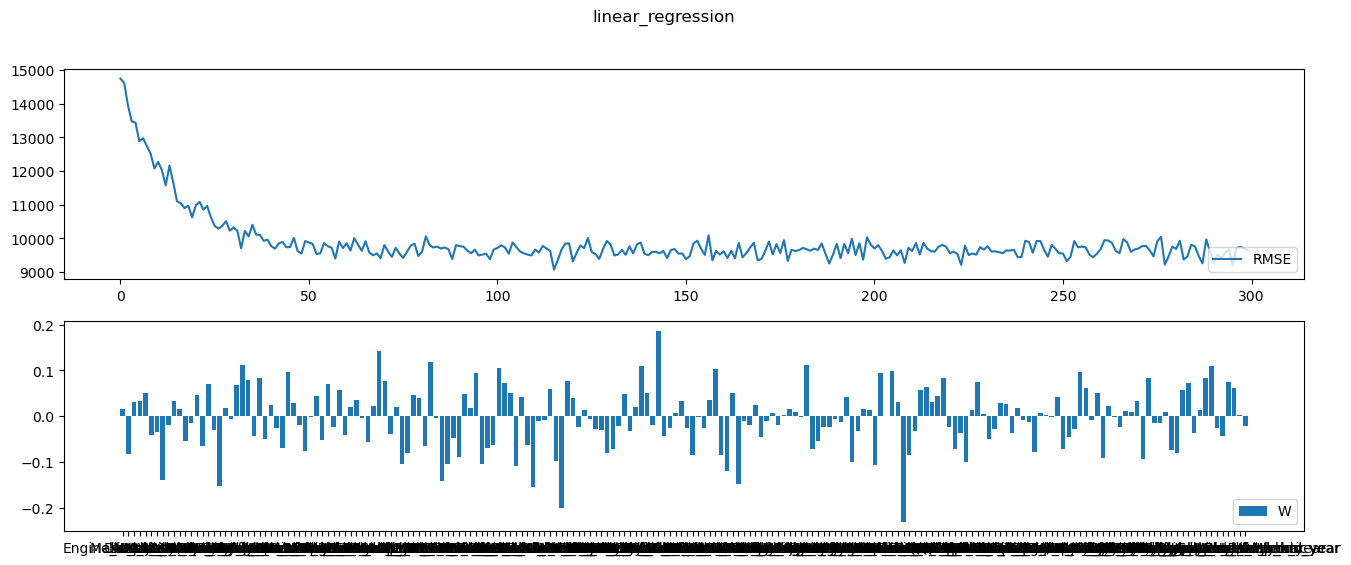

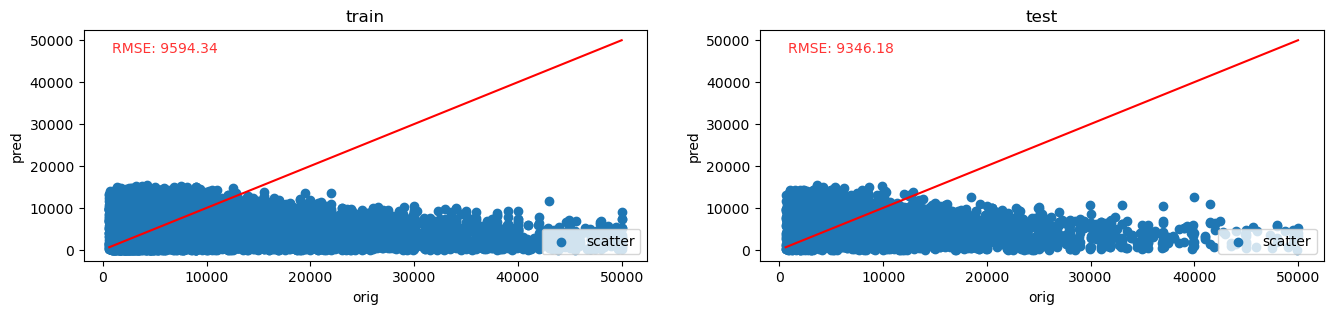

In [1377]:
train_and_test(cars_onehot, linear_regression, {"_lr":1e-12, "_batch":5000, "_epochs":300})

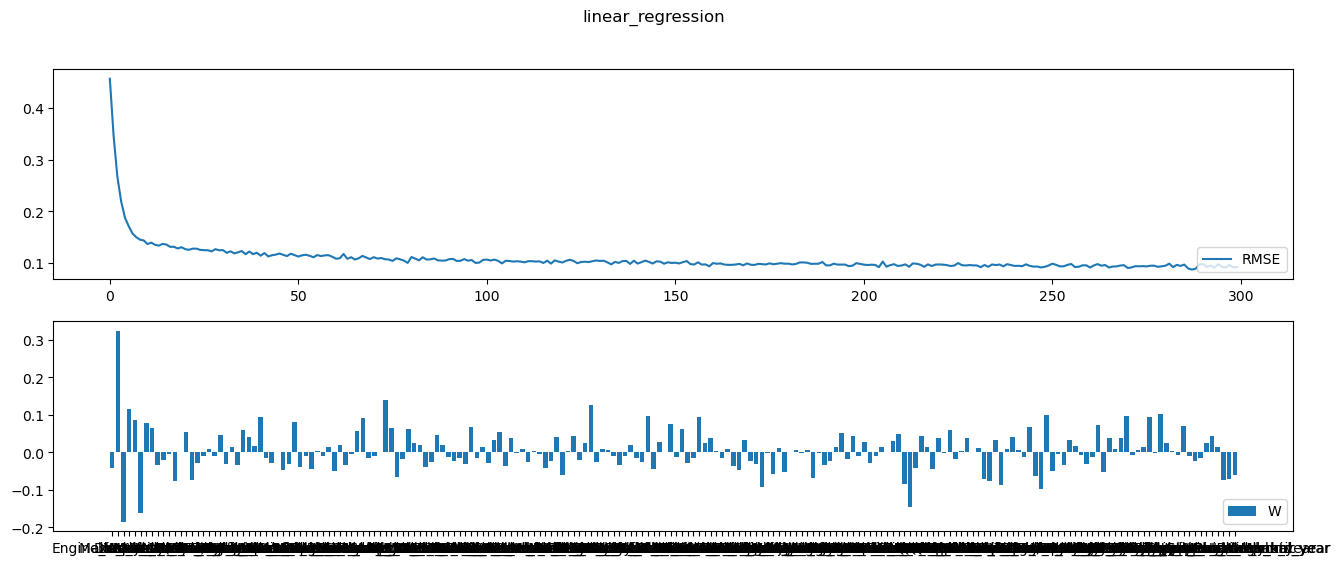

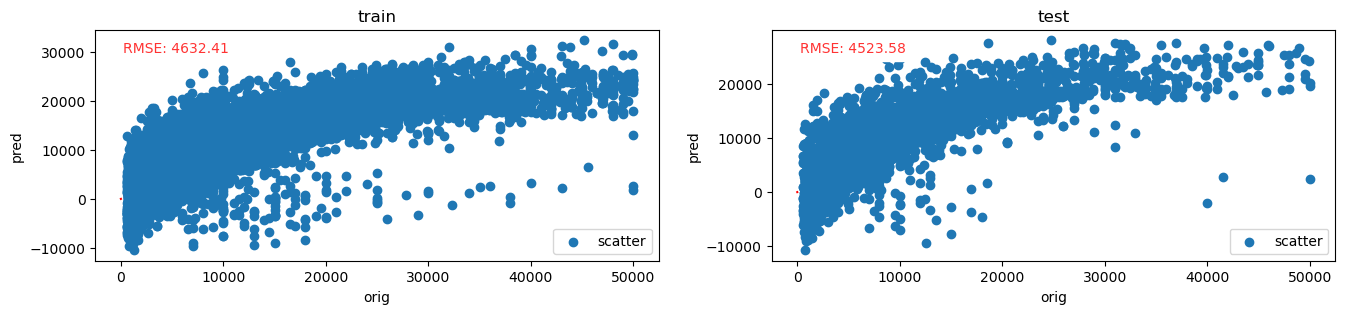

In [1378]:
train_and_test(cars_onehot, linear_regression, {"_minmax": True, "_lr":0.5, "_batch":5000, "_epochs":300}, {"_minmax": True})

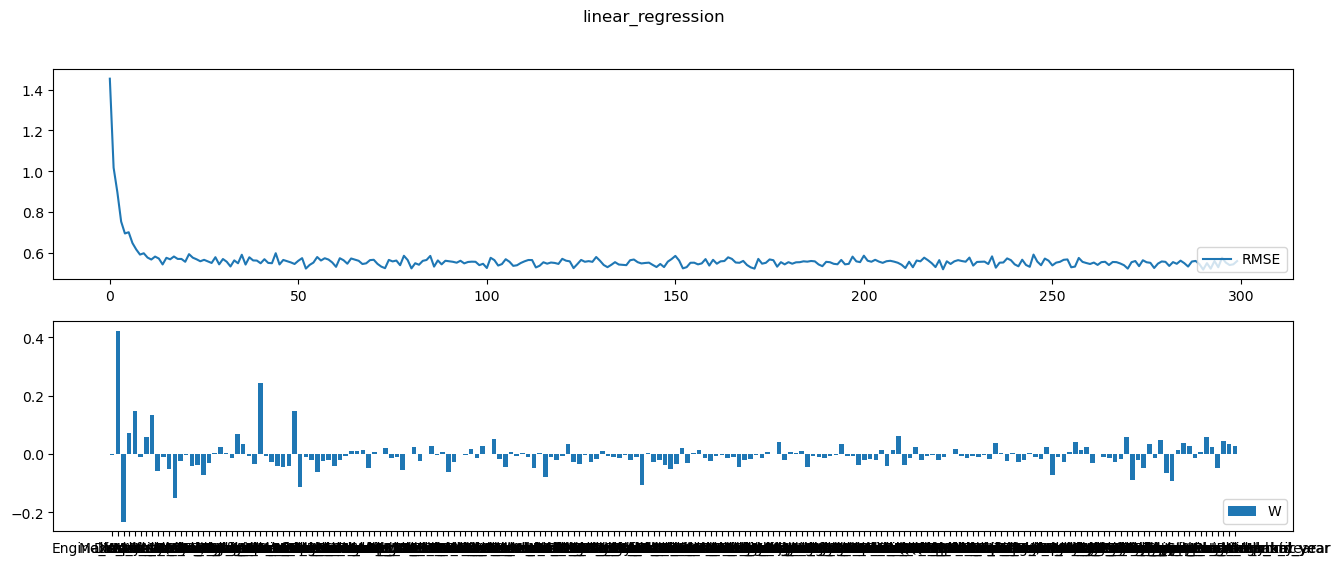

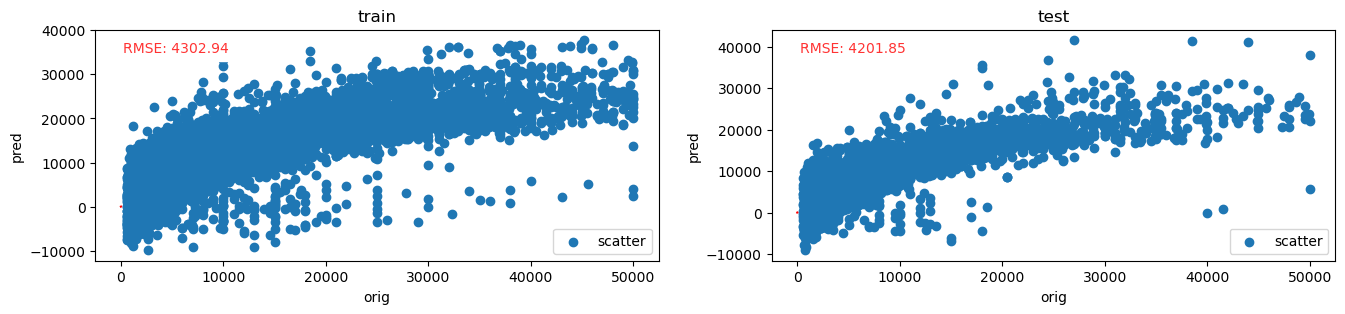

In [1380]:
train_and_test(cars_onehot, linear_regression, {"_std": True, "_lr":0.2, "_batch":5000, "_epochs":300}, {"_std": True})